In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
# data_filename = "bs4_nltk.pkl"
data_filename = "bs4.pkl"
df_base = pd.read_pickle(data_path + data_filename)
df_top = pd.read_pickle(data_path + 'Top_Tags.pkl')
body_corpus = load(data_path + 'body_corpus.joblib')

In [4]:
df_base

,Id,Title,Body,Tags,Bs4_Body,Code,Bs4_Tags
0,59549234,How to determine the smallest common divisor o...,<p>I was asked the following question during a...,<string><algorithm>,I was asked the following question during a jo...,"Given two strings s & t, determine if s is div...","[string, algorithm]"
1,59549281,How to use a trait object that contains a meth...,<p>What's the correct way to use a trait objec...,<rust>,What's the correct way to use a trait object t...,Selftrait Foo { fn gen(&mut self) -> &Self...,[rust]
2,59549471,Why a named function declaration isn't hoisted...,<p>is putting the function declaration beside ...,<javascript>,is putting the function declaration beside the...,// Hoisting doesn't work in here\r function ou...,[javascript]
3,59549568,Getting value of input causing flickering in R...,<p>I am attempting to track the value of two l...,<javascript><css><reactjs><react-hooks><react-...,I am attempting to track the value of two logi...,"profile_tile.jsimport React, { useState } from...","[javascript, css, reactjs]"
4,59549600,How to assign a vector of atomic types?,<p>How can I assign the members of a vector wi...,<c++><multithreading><c++11><stdvector><stdato...,How can I assign the members of a vector with ...,#include <iostream> #include <thread> #include...,"[c++, multithreading, c++11]"
...,...,...,...,...,...,...,...
49995,61503153,NullReferenceException in SimpleInjector.Conta...,<p>I'm still in the process of getting into WP...,<c#><wpf><xaml><simple-injector>,I'm still in the process of getting into WPF a...,"MainWindow <Window x:Class=""WpfPlayground.M...","[c#, wpf, xaml]"
49996,61503183,How can I add grid lines to a catplot in seaborn?,<p>How can I add grid lines (vertically and ho...,<python><seaborn><catplot>,How can I add grid lines (vertically and horiz...,"seabornaximport seaborn as sns sns.set(style=""...",[python]
49997,61503185,Standard deviation only for data that meets tw...,<p>I am trying to calculate the standard devia...,<excel><excel-formula>,I am trying to calculate the standard deviatio...,Region Variety Yield A Z1 1500 B Z1 210...,"[excel, excel-formula]"
49998,61503205,How to properly raise exception in TensorFlow ...,<p>I want to raise a <code>tf.errors.InvalidAr...,<python><python-3.x><tensorflow><tensorflow2.0...,I want to raise a exception dependent on the ...,tf.errors.InvalidArgumentErrortf.debugging.ass...,"[python, python-3.x, tensorflow]"


In [5]:
df = pd.concat([df_base[['Title','Bs4_Body']],df_top], axis=1)[:10000]

In [6]:
mlb = MultiLabelBinarizer()
y_tags = mlb.fit_transform(df['Tags_T50'])

In [7]:
np.where(mlb.classes_=="python")

(array([39], dtype=int64),)

In [8]:
# y_tags = y_tags[:,39]

In [9]:
# dataset =  tf.data.Dataset.from_tensor_slices((df['Bs4_Body'].values, y_tags))
dataset =  tf.data.Dataset.from_tensor_slices((df['Title'].values, y_tags))

In [33]:
for example, tag in dataset.take(3):
    print('texts: ', example.numpy())
    print('Tags: ', tag.numpy())

texts:  b'How to determine the smallest common divisor of a string?'
Tags:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
texts:  b'How to use a trait object that contains a method that returns a reference to Self?'
Tags:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
texts:  b"Why a named function declaration isn't hoisted if you put it inside the return statement?"
Tags:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
dataset.cardinality().numpy()*.8

8000.0

In [34]:
split_ratio = .8
train_dataset, test_dataset = dataset.take(dataset.cardinality().numpy()*split_ratio), dataset.skip(dataset.cardinality().numpy()*split_ratio)

In [51]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [52]:
for example, label in train_dataset.take(3):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  [b'How to update Django query object in a for loop'
 b'Using loc on two columns to perform calculations that replace values of another column'
 b'Windows Script Host Error 800A03EA on Express.js code'
 b'How to use std::set_terminate with SetUnhandledExceptionFilter?'
 b'React Material UI - Make Slider update state'
 b'Extracting last word/text multiple matching logstash'
 b'Are returned BehaviourSubjects (as Observable) effected by take(1) or unsubscribe?'
 b'Matplotlib RectangleSelector disappears when new image loaded in wxPython panel'
 b'maven dependency - which dependency is using unwanted jar?'
 b'R: given a matrix of 0 and 1s create matrix showing repetition between columns in rows'
 b'How to remap or revert a point into its former coordinate system after warpAffine has transformed it?'
 b'Using any or none on the hash keys and values in Raku'
 b"Can't access Service via Kubernetes Service with specified endpoints"
 b'How do I create a list in a separate Dataframe column

In [53]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)

In [54]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [55]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'in', 'a', 'how', 'the', 'of', 'with', 'and',
       'is', 'from', 'on', 'using', 'for', 'i', 'not', 'an', 'value',
       'function'], dtype='<U16')

In [56]:
encoded_example = encoder(example).numpy()
encoded_example

array([[ 10,  66,   4, 132,  57,   1,  51, 360,   7,  13, 752,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 50,  10,   4,   1,  57, 402,   4,   9,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5,   2,  27,  55, 254,   7,   4, 354,   1,   3,  23,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 15, 456,   2, 106,  12,  73,   1,   3, 185,   3,  78, 362, 782,
        129, 105,  73,   1,  11,   1,  83,  41,   1,   0,   0],
       [229,   1, 602,  78, 714,  10,   1,   9,   1,  92,   6,   1,   7,
          6, 714,  10,   3,   6, 543,  64,   0,   0,   0,   0],
       [ 69,   1, 559,   3, 122,   9, 353,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   9, 270,   6, 520,  10,   1, 571,  92,  12,   6,   1,   1,
          1,  10,   1,   9,  12,   6,   1, 262,  36,   1, 862],
       [ 10,  66,   4, 670,  54,   2,   1

In [57]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'Is there a difference between these two methods of using express middleware?'
Round-trip:  is there a difference between [UNK] two methods of using express [UNK]            

Original:  b'What is a diference between ((int) a) and (int(a))?'
Round-trip:  what is a [UNK] between int a and [UNK]               

Original:  b"How to get all names of a classes' classmethods in Python"
Round-trip:  how to get all names of a classes [UNK] in python             



In [58]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(51, activation='sigmoid')
])

In [59]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True]


In [60]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [61]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [62]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [63]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30
                   )

Epoch 1/10
250/250 [==============================] - 13s 30ms/step - loss: 0.6199 - accuracy: 0.0212 - val_loss: 0.1561 - val_accuracy: 0.0198
Epoch 2/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1646 - accuracy: 0.0545 - val_loss: 0.1289 - val_accuracy: 0.1135
Epoch 3/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1407 - accuracy: 0.0794 - val_loss: 0.1227 - val_accuracy: 0.0979
Epoch 4/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1343 - accuracy: 0.0867 - val_loss: 0.1208 - val_accuracy: 0.0969
Epoch 5/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1281 - accuracy: 0.0864 - val_loss: 0.1196 - val_accuracy: 0.0958
Epoch 6/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1279 - accuracy: 0.0963 - val_loss: 0.1190 - val_accuracy: 0.0906
Epoch 7/10
250/250 [==============================] - 6s 22ms/step - loss: 0.1266 - accuracy: 0.0933 - val_loss: 0.1189 - val_accuracy: 0.094

In [31]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

32/32 [==============================] - 2s 53ms/step - loss: 0.1196 - accuracy: 0.0820
Test Loss: 0.11957009136676788
Test Accuracy: 0.0820000022649765


(0.0, 0.6043519366532564)

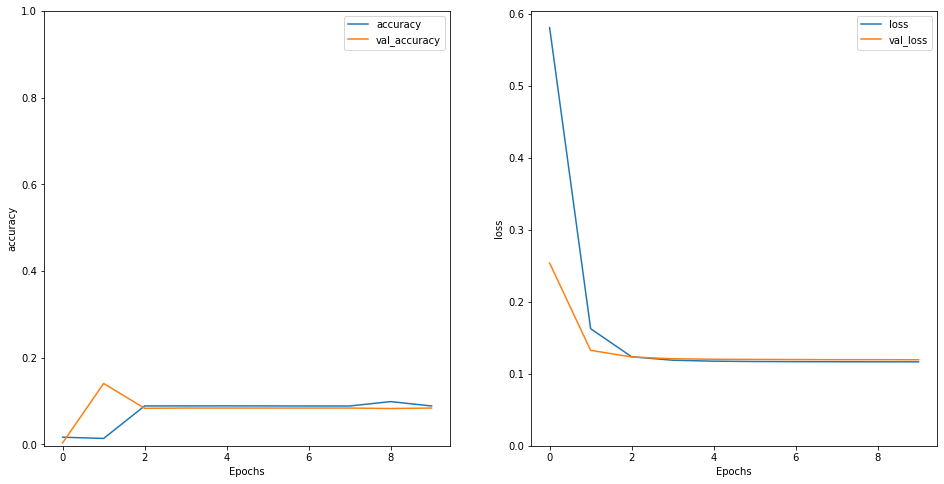

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)